In [1]:
import numpy as np
import pandas as pd
import pickle

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.display.max_columns = 100

import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [5]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
     
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые льготы
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка благонадежности клиента (скоринговый балл, полученный из другого источника)
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
TRAIN_DATASET_PATH = 'datasets/course_project_train.csv'
TEST_DATASET_PATH = 'datasets/course_project_test.csv'

PREDICTED_CREDIT_DEFAULT_PATH  = 'AVasilev_predictions.csv'

MODEL_FILE_PATH = 'model.pkl'

### Обзор обучающего датасета

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
print(f'Форма датасета: {df_train.shape}')

(7500, 17)

In [8]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [9]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718267
1    0.281733
Name: Credit Default, dtype: float64

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [11]:
print(f'Пропущеные значения:\n{df_train.isnull().sum()}')

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

### Подготовка обучающего датасета

**Обработка выбросов**

In [12]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


*Maximum Open Credit*

In [13]:
median_open_credit = df_train['Maximum Open Credit'].median()
df_train.loc[df_train['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [14]:
median_loan_ammount = df_train['Current Loan Amount'].median()
df_train.loc[df_train['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [15]:
df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] = df_train.loc[df_train['Credit Score'] > 751, 'Credit Score'] / 10

**Обработка пропусков**

*Annual Income*

In [16]:
for i in df_train.index[df_train['Annual Income'].isnull()]:
    monthly_debt = df_train.iloc[i, 14]
    df_train.iat[i, 1] = df_train.loc[(df_train['Monthly Debt'] < monthly_debt * 1.2) & 
                                      (df_train['Monthly Debt'] > monthly_debt * 0.8), 'Monthly Debt'].median()

In [17]:
med_anual_income = df_train['Annual Income'].median()
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

*Years in current job*

In [18]:
job_years = df_train['Years in current job'].mode()[0]
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = job_years

*Credit Score*

In [19]:
credit_score = {}
for value in df_train['Years of Credit History'].unique():
    credit_score[value] = df_train.loc[df_train['Years of Credit History'] == value, 'Credit Score'].median()

In [20]:
for i in df_train.index[df_train['Credit Score'].isnull()]:
    cred_history_years = df_train.iloc[i, 5]
    df_train.iat[i, 15] = credit_score[cred_history_years]

In [21]:
median_credit_score = df_train['Credit Score'].median()
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = median_credit_score

*Bankruptcies*

In [22]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].median()

*Months since last delinquent*  
Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

In [23]:
df_train = df_train.drop(columns='Months since last delinquent')

In [24]:
df_train.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

**Создание дополнительных признаков**

*Is Loan Big - равен 1, если текущая сумма кредита больше медианного значения*

In [25]:
med_cur_ammount = df_train['Current Loan Amount'].median()

In [26]:
is_big_loan = [1 if el > med_cur_ammount else 0 for el in df_train['Current Loan Amount']]

In [27]:
df_train['Is Loan Big'] = is_big_loan

*Mean Home Ownership Income - средний доход домовладений по типам*

In [28]:
home_own_types = df_train['Home Ownership'].unique()
print(f"Home ownership's types:\t {home_own_types}")

Home ownership's types:	 ['Own Home' 'Home Mortgage' 'Rent' 'Have Mortgage']


In [29]:
mean_home_own_income_by_type = [df_train.loc[df_train['Home Ownership'] == el, 'Annual Income'].mean() 
                                for el in home_own_types]

df_mean_income = pd.DataFrame([home_own_types, mean_home_own_income_by_type], index=['Home Ownership', 'Mean Annual Income'])
df_mean_income = df_mean_income.T

mean_home_own_income_temp = [df_mean_income.loc[df_mean_income['Home Ownership'] == el, 'Mean Annual Income'].tolist() 
                                                     for el in df_train['Home Ownership']]
mean_home_own_income = [el[0] for el in mean_home_own_income_temp]

In [30]:
df_train['Mean Home Ownership Income'] = mean_home_own_income

*Debt-to-income ratio - отношение ежемесячного долга домовладения к его ежемесячному доходу*

In [31]:
df_train['Debt-to-income ratio'] = round(df_train['Monthly Debt'] / (df_train['Annual Income'] / 12), 3)

*Is Payment High Равен 1, если Debt-to-income ratio более 0.43**  
Считается, что при более высокой доле обязательств по кредиту относительно общего дохода, становится затруднительно отвечать по своим финансовым обязательствам. Данное обстоятельство ведет к повышению риска просрочки платежей по ним.

In [32]:
is_payment_high = [1 if el > 0.43 else 0 for el in df_train['Debt-to-income ratio']]
df_train['Is Payment High'] = is_payment_high

In [33]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,1.0,debt consolidation,Short Term,309573.0,47386.0,7914.0,749.0,0,1,9.324772e+05,0.197,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1,0,9.324772e+05,0.215,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,0.0,debt consolidation,Short Term,309573.0,308389.0,13651.0,742.0,0,1,1.247308e+06,0.218,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0,0,9.324772e+05,0.169,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0,0,9.371076e+05,0.111,0


**Обзор категориальных переменных**

In [34]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

Создаю новые числовые признаки на основе Term и Home Ownership 

In [35]:
df_train['Term Binary'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [36]:
df_train['Home Ownership digit'] = df_train['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

Использую One-Hot Encoding для приведения признаков Purpose и Years in current job к числовому формату

In [37]:
obj_columns = ['Purpose', 'Years in current job']

In [38]:
train_dummies = pd.get_dummies(df_train[obj_columns])
df_train = pd.concat([df_train, train_dummies], axis=1)

In [40]:
print(f'Получившаяся форма тренировочного датасета: {df_train.shape}')

Получившаяся форма тренировочного датасета: (7500, 48)


### Анализ целевой переменной

In [41]:
df_base = pd.read_csv(TRAIN_DATASET_PATH)

In [42]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(['Months since last delinquent', 'Credit Default']).tolist()
BASE_FEATURE_NAMES.append('Is Loan Big')
BASE_FEATURE_NAMES.append('Mean Home Ownership Income')
BASE_FEATURE_NAMES.append('Debt-to-income ratio')
BASE_FEATURE_NAMES.append('Is Payment High')
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

**Обзор распределения**

In [43]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

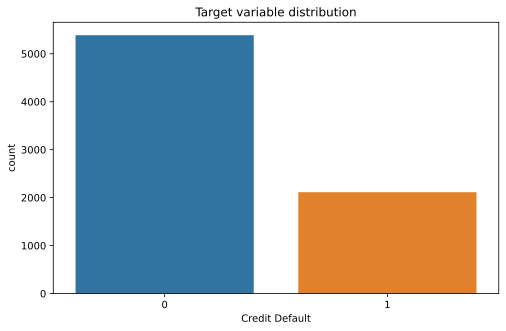

In [44]:
plt.figure(figsize=(8, 5))

sns.countplot(x=TARGET_NAME, data=df_train)

plt.title('Target variable distribution')
plt.show()

**Корреляция с базовыми признаками**

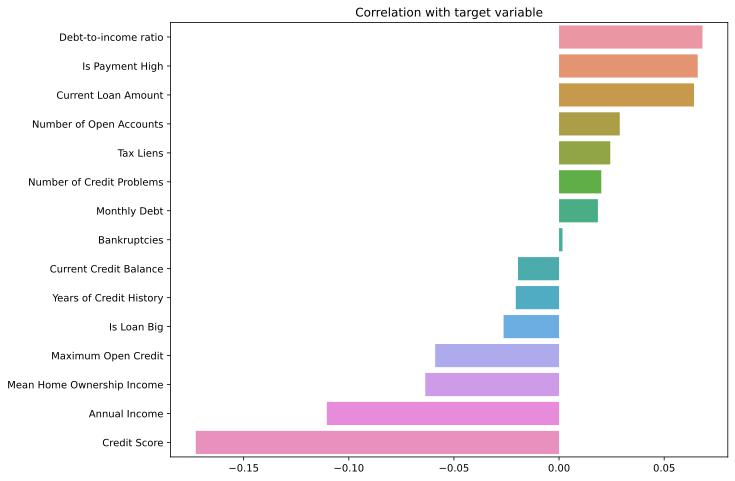

In [45]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

*На основании данного графика, принял решение произвести оценку признаков с корреляцией более 0.1 по модулю: Credit Score и Annual Income.*

**Оценка признака "Credit Score" в разрезе целевой переменной**

In [46]:
credit_score_with_target_s = df_train[['Credit Score', TARGET_NAME]].sample(1000)
credit_score_s = credit_score_with_target_s['Credit Score']
credit_score_target_0 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 0]
credit_score_target_1 = credit_score_s[credit_score_with_target_s[TARGET_NAME] == 1]

*Наблюдение*  
Есть вероятность, что между признаком "Credit Score" и целевой переменной существует некоторая функциональная зависимость.

*Гипотеза*   
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [47]:
shapiro(credit_score_s)

ShapiroResult(statistic=0.8484784960746765, pvalue=7.191584912680996e-30)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.

*Для достоверности провожу визуальную оценку распределения признака, а так же сторою QQ-график*

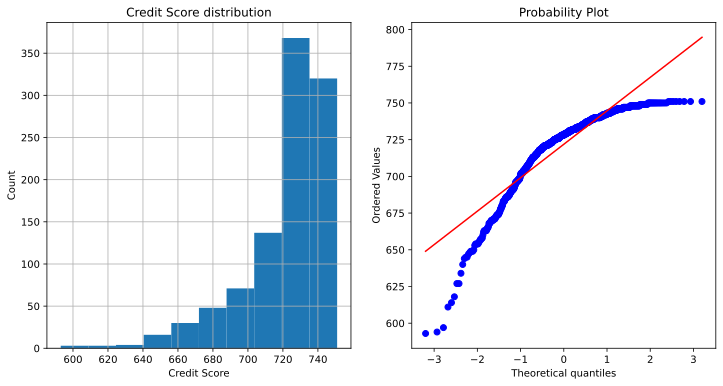

In [48]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(121)
ax1.set_xlabel('Credit Score')
ax1.set_ylabel('Count')
ax1.set_title('Credit Score distribution')
credit_score_s.hist()

plt.subplot(122)
probplot(credit_score_s, dist='norm', plot=plt)

plt.show()

*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [49]:
mannwhitneyu(credit_score_target_0, credit_score_target_1)

MannwhitneyuResult(statistic=75247.5, pvalue=5.642475119488831e-10)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.

*Строю доверительные интервалы для средних значений каждой из двух групп и сравниваю их для дополнительной проверки.*

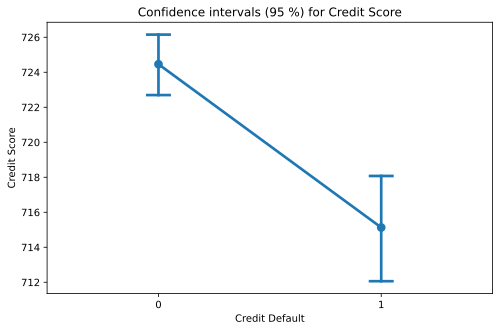

In [50]:
plt.figure(figsize=(8, 5))

sns.pointplot(x=TARGET_NAME, y='Credit Score', data=credit_score_with_target_s, capsize=.1)

plt.title('Confidence intervals (95 %) for Credit Score')
plt.show()

График подтверждает, что интервалы не пересекаются, что подтверждает результаты полученные с помощью критерия Манна-Уитни.

Полученные разультаты означают, что группы из которых взяты данные выборки, с вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

**Оценка признака "Annual Income" в разрезе целевой переменной**  
Произвожу оценку данного признака аналогично предыдущему

In [51]:
annual_income_with_target_s = df_train[['Annual Income', TARGET_NAME]].sample(1000)
annual_income_s = annual_income_with_target_s['Annual Income']
annual_income_target_0 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 0]
annual_income_target_1 = annual_income_s[annual_income_with_target_s[TARGET_NAME] == 1]

*Наблюдение*  
Есть вероятность, что между признаком "Annual Income" и целевой переменной существует некоторая функциональная зависимость.

*Гипотеза* 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий Стьюдента (t-тест)
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

*Проверка распределения признака на "нормальность" с помощью критерия Шапиро-Уилка*

In [52]:
shapiro(annual_income_s)

ShapiroResult(statistic=0.8891326189041138, pvalue=3.5564878709979744e-26)

Так как значение p-value сильно меньше 0.05, можно сделать вывод, что гипотеза о "нормальности" отвергается.  
*Оцениваю эквивалентность мат. ожиданий в исследуемых группах с помощью критерия Манна-Уитни.*

In [53]:
mannwhitneyu(annual_income_target_0, annual_income_target_1)

MannwhitneyuResult(statistic=78290.5, pvalue=7.745052759486965e-08)

Согласно значению p-value, гипотеза о равности мат. ожиданий отвергается.  
Полученные разультаты означают, что группы из которых взяты данные выборки, с допускаемой вероятностью 95%, имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

### Подготовка к обучению модели
**Отбор признаков**

In [54]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                     'Number of Credit Problems', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 
                     'Monthly Debt', 'Credit Score', 'Mean Home Ownership Income', 'Debt-to-income ratio']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

NEW_BINARY_FEATURES = ['Is Loan Big', 'Is Payment High']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + NEW_BINARY_FEATURES + NEW_FEATURE_NAMES

**Нормализация данных**

In [55]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df = df_norm.copy()

**Балансировка целевой переменной**

In [56]:
df_balanced = balance_df_by_target(df, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

**Разделение датасета на train и valid**

In [57]:
X = df_balanced[SELECTED_FEATURE_NAMES]
y = df_balanced[TARGET_NAME]

In [58]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=27)

### Обучение модели на тренировочных данных  
*Мной был выбран CatBoostClassifier для обучения модели, т.к. он показал результат лучше по сравнению с другими алгоритмами*

In [101]:
сatb_model = catb.CatBoostClassifier(silent=True, random_state=27)
сatb_model.fit(X_train, y_train)

y_train_pred = сatb_model.predict(X_train)
y_valid_pred = сatb_model.predict(X_valid)
y_valid_pred_probs = сatb_model.predict_proba(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      3747
           1       0.87      0.86      0.86      2982

    accuracy                           0.88      6729
   macro avg       0.88      0.88      0.88      6729
weighted avg       0.88      0.88      0.88      6729

VALID

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      1640
           1       0.67      0.70      0.68      1244

    accuracy                           0.72      2884
   macro avg       0.72      0.72      0.72      2884
weighted avg       0.72      0.72      0.72      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1215  425
1                377  867


**Обучение финальной модели**  
Для обучения использую только 15 признаков, показавший наибольшую значимость для обучения модели

In [102]:
important_features_top = show_feature_importances(X.columns, сatb_model.feature_importances_, get_top=15)
print(f'15 наиболее важных признаков:\n{important_features_top}')

15 наиболее важных признаков:
['Current Loan Amount', 'Is Loan Big', 'Credit Score', 'Maximum Open Credit', 'Years of Credit History', 'Debt-to-income ratio', 'Current Credit Balance', 'Annual Income', 'Monthly Debt', 'Number of Open Accounts', 'Term Binary', 'Mean Home Ownership Income', 'Home Ownership digit', 'Number of Credit Problems', 'Purpose_debt consolidation']


In [103]:
final_model = catb.CatBoostClassifier(l2_leaf_reg=100,
                                      silent=True, random_state=27)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred = final_model.predict(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3747
           1       0.79      0.77      0.78      2982

    accuracy                           0.81      6729
   macro avg       0.81      0.81      0.81      6729
weighted avg       0.81      0.81      0.81      6729

VALID

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      1640
           1       0.64      0.64      0.64      1244

    accuracy                           0.69      2884
   macro avg       0.69      0.69      0.69      2884
weighted avg       0.69      0.69      0.69      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1196  444
1                442  802


**Перекрестная проверка для дополнительного подтверждения получившихся результатов по заданной метрике**

In [62]:
cv_score_f1 = cross_val_score(final_model, X, y, scoring=('f1'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
print(f'Максимальное значение F1:   {round(cv_score_f1.mean() + cv_score_f1.std(), 3)}') 
print(f'Среднее значение F1:        {round(cv_score_f1.mean(), 3)}')
print(f'Минимальное значение F1:    {round(cv_score_f1.mean() - cv_score_f1.std(), 3)}')

Максимальное значение F1:   0.665
Среднее значение F1:        0.656
Минимальное значение F1:    0.647
Wall time: 1min 4s


In [63]:
cv_score_precision = cross_val_score(final_model, X, y, scoring=('precision'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
print(f'Максимальное значение Precision:   {round(cv_score_precision.mean() + cv_score_precision.std(), 3)}') 
print(f'Среднее значение Precision:        {round(cv_score_precision.mean(), 3)}')
print(f'Минимальное значение Precision:    {round(cv_score_precision.mean() - cv_score_precision.std(), 3)}')

Максимальное значение Precision:   0.687
Среднее значение Precision:        0.671
Минимальное значение Precision:    0.656
Wall time: 1min 4s


In [64]:
cv_score_recall = cross_val_score(final_model, X, y, scoring=('recall'), cv=KFold(n_splits=5, shuffle=True, random_state=27))
print(f'Максимальное значение Recall:   {round(cv_score_recall.mean() + cv_score_recall.std(), 3)}') 
print(f'Среднее значение Recall:        {round(cv_score_recall.mean(), 3)}')
print(f'Минимальное значение Recall:    {round(cv_score_recall.mean() - cv_score_recall.std(), 3)}')

Максимальное значение Recall:   0.661
Среднее значение Recall:        0.642
Минимальное значение Recall:    0.623
Wall time: 1min 3s


**Сохранение модели**

In [65]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Подготовка тестового датасета

**Обзор тестового датасета**

In [66]:
df_test = pd.read_csv(TEST_DATASET_PATH)
print(f'Форма датасета: {df_test.shape}')

(2500, 16)

In [67]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [68]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [69]:
print(f'Пропущенные значения:\n{df_test.isnull().sum()}')

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

**Обработка выбросов**

In [70]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


*Maximum Open Credit*

In [71]:
df_test.loc[df_test['Maximum Open Credit'] > 1e+07, 'Maximum Open Credit'] = median_open_credit

*Current Loan Amount*

In [72]:
df_test.loc[df_test['Current Loan Amount'] > 1e+06, 'Current Loan Amount'] = median_loan_ammount

*Credit Score*

In [73]:
df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] = df_test.loc[df_test['Credit Score'] > 751, 'Credit Score'] / 10

**Обработка пропусков**

*Annual Income*

In [74]:
for i in df_test.index[df_test['Annual Income'].isnull()]:
    monthly_debt = df_test.iloc[i, 14]
    df_test.iat[i, 1] = df_test.loc[(df_train['Monthly Debt'] < monthly_debt * 1.2) & 
                                      (df_train['Monthly Debt'] > monthly_debt * 0.8), 'Monthly Debt'].median()

In [75]:
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = med_anual_income

*Years in current job*

In [76]:
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = job_years

*Credit Score*  
Использую конструкцию try except, т.к. словарm credit_score содержит не все значения из тестового датасета.  
Им присваиваю медианное значение

In [77]:
try:
    for i in df_test.index[df_test['Credit Score'].isnull()]:
        cred_history_years = df_test.iloc[i, 5]
        df_test.iat[i, 15] = credit_score[cred_history_years]
except KeyError:
    df_test.iat[i, 15] = median_credit_score

In [78]:
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = median_credit_score

*Bankruptcies*

In [79]:
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].median()

*Months since last delinquent*  
Т.к. пропущенных значений больше половины, удаляю данный признак из датасета

In [80]:
df_test = df_test.drop(columns='Months since last delinquent')

In [81]:
df_test.isnull().sum()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
dtype: int64

**Создание дополнительных признаков**

*Is Loan Big*

In [82]:
is_big_loan_test = [1 if el > med_cur_ammount else 0 for el in df_test['Current Loan Amount']]

In [83]:
df_test['Is Loan Big'] = is_big_loan_test

*Mean Home Ownership Income*

In [84]:
mean_home_own_income_temp_test = [df_mean_income.loc[df_mean_income['Home Ownership'] == el, 'Mean Annual Income'].tolist() 
                                                     for el in df_test['Home Ownership']]
mean_home_own_income_test = [el[0] for el in mean_home_own_income_temp_test]

In [85]:
df_test['Mean Home Ownership Income'] = mean_home_own_income_test

*Debt-to-income ratio*

In [86]:
df_test['Debt-to-income ratio'] = round(df_test['Monthly Debt'] / (df_test['Annual Income'] / 12), 3)

*Is Payment High**

In [87]:
is_payment_high_test = [1 if el > 0.43 else 0 for el in df_test['Debt-to-income ratio']]
df_test['Is Payment High'] = is_payment_high_test

**Обзор категориальных переменных**

In [89]:
for cat_colname in df_test.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_test[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    1225
Rent             1020
Own Home          248
Have Mortgage       7
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    896
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      1973
other                    240
home improvements        140
buy a car                 34
business loan             30
medical bills             27
buy house                 19
take a trip               14
major purchase             9
small business             5
vacation                   3
educational expenses       3
wedding                    2
moving               

In [90]:
df_test['Term Binary'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

In [91]:
df_test['Home Ownership digit'] = df_test['Home Ownership'].map({'Home Mortgage':'0', 'Rent':'1',\
                                    'Own Home': '2', 'Have Mortgage': '3'}).astype(int)

In [92]:
test_dummies = pd.get_dummies(df_test[obj_columns])
df_test = pd.concat([df_test, test_dummies], axis=1)

In [93]:
# Добавляю столбец Purpose_renewable energy с нулевыми значениями, чтобы привести тестовый датасет в единую форму с обучающим
df_test['Purpose_renewable energy'] = 0

In [94]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High,Term Binary,Home Ownership digit,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_renewable energy
0,Rent,17234.0,4 years,0.0,9.0,12.5,220968.0,0.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,729.0,0,9.371076e+05,4.744,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0,0,9.371076e+05,0.120,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,726.0,0,1.247308e+06,0.195,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0,0,1.247308e+06,0.271,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0,1,1.247308e+06,0.218,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


**Нормализация данных**

In [95]:
df_norm_test = df_test.copy()
df_norm_test[NUM_FEATURE_NAMES] = scaler.transform(df_norm_test[NUM_FEATURE_NAMES])

df_test = df_norm_test.copy()

In [96]:
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Is Loan Big,Mean Home Ownership Income,Debt-to-income ratio,Is Payment High,Term Binary,Home Ownership digit,Purpose_business loan,Purpose_buy a car,Purpose_buy house,Purpose_debt consolidation,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding,Years in current job_1 year,Years in current job_10+ years,Years in current job_2 years,Years in current job_3 years,Years in current job_4 years,Years in current job_5 years,Years in current job_6 years,Years in current job_7 years,Years in current job_8 years,Years in current job_9 years,Years in current job_< 1 year,Purpose_renewable energy
0,Rent,-1.150084,4 years,-0.110953,-0.434123,-0.826171,-0.626394,-0.340979,-0.337099,debt consolidation,Short Term,-0.855503,-0.578660,-0.964404,0.289070,0,-0.960030,0.423109,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,Rent,-0.919327,1 year,-0.110953,-1.045295,2.042545,-0.871123,-0.340979,-0.337099,educational expenses,Short Term,-1.346639,-0.767016,-1.341313,-0.893413,0,-0.960030,-0.521331,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,0.070673,3 years,-0.110953,-0.230398,-0.655753,-0.650668,-0.340979,-0.337099,debt consolidation,Short Term,-0.635480,-0.450977,0.034760,0.170821,0,1.029216,-0.506012,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,Home Mortgage,0.143548,10+ years,-0.110953,0.991947,-0.187101,-0.277391,-0.340979,-0.337099,debt consolidation,Short Term,-0.535096,-0.241102,0.775161,0.683230,0,1.029216,-0.490490,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,Home Mortgage,1.348534,6 years,-0.110953,-0.026674,0.750203,0.836304,-0.340979,-0.337099,debt consolidation,Long Term,2.733923,0.426483,2.036777,-0.617500,1,1.029216,-0.501315,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Предсказание на тестовом датасете

In [97]:
y_test_pred = final_model.predict(df_test[important_features_top])

In [98]:
df_test_preds = pd.DataFrame(data=y_test_pred, columns=[TARGET_NAME])
df_test_preds.shape

(2500, 1)

**Сохраняю получившийся датасет в файл .csv**

In [99]:
df_test_preds.to_csv(PREDICTED_CREDIT_DEFAULT_PATH, index=False, encoding='utf-8')